In [1]:
%matplotlib notebook


# Fitting configuration

For each line fitting, $LiMe$ provides two kind of measurements. Those based on the [integration  of the flux](https://lime-stable.readthedocs.io/en/latest/documentation/measurements.html#integrated-properties) within the line band and those which assume a shape for the line profile. By default, $LiMe$ assumes a single Gaussian profile, which is parametrised by the following formula:

$F_{\lambda}=\sum_{i}A_{i}e^{-\left(\frac{\lambda-\mu_{i}}{2\sigma_{i}}\right)^{2}} + c_{\lambda}$


where, one the left-hand side $F_{\lambda}$ is the line flux. On the right-hand side, we have two components: The first one is the Gaussian profile flux,  where $A_{i}$ is the height of a Gaussian profile above the continuum level, $\mu_{i}$ is the center of the of Gaussian profile and $\sigma_{i}$ is the standard deviation of the profile. The second component is the continuum level of the line $c_{\lambda}$, $LiMe$ computes this continuum from the adjacent bands assuming a linear relation and by default it is kept constanst during the fitting.

<div class="alert alert-info">

**Please remember:** By default $LiMe$ assumes a single Gaussian profile in the line measurements. To fit anything more complex, the [line label](https://lime-stable.readthedocs.io/en/latest/inputs/2_Line_labels.html#Modularity-component) must have the blended suffix **(_b)** and the user needs to specify the **line components** in the profile configuration
</div>

To show some examples regarding the fitting configuration notation, we are going to use some data from the [3rd tutorial](https://lime-stable.readthedocs.io/en/latest/tutorials/notebook3_CompleteSpectrumFitting.html). You can download this documentation page as a [notebook](https://lime-stable.readthedocs.io/en/latest/inputs/4_Fitting_configuration.html) from the library github.

## Configuration files

Let's start by loading the libraries to run the samples:

In [2]:
import numpy as np
from astropy.io import fits
from IPython.display import Image, display
from pathlib import Path
import lime

Now we proceed to load the scientific data:

In [3]:
def import_osiris_fits(file_address, ext=0):

    # Open the fits file
    with fits.open(file_address) as hdul:
        data, header = hdul[ext].data, hdul[ext].header

    # Reconstruct the wavelength array from the header data
    w_min, dw, n_pix = header['CRVAL1'],  header['CD1_1'], header['NAXIS1']
    w_max = w_min + dw * n_pix
    wavelength = np.linspace(w_min, w_max, n_pix, endpoint=False)

    return wavelength, data, header

In [4]:
# State the data files
obsFitsFile = '../sample_data/gp121903_osiris.fits'
lineBandsFile = '../sample_data/osiris_bands.txt'
configFile = '../sample_data/osiris.toml'

# Load spectrum
wave, flux, header = import_osiris_fits(obsFitsFile)

# Load line bands
bands_df = lime.load_log(lineBandsFile)

Now, we need to read the configuration file. This is a text file which uses the [toml](https://toml.io/en/) configuration format. In the case of the ``osiris.toml`` file:

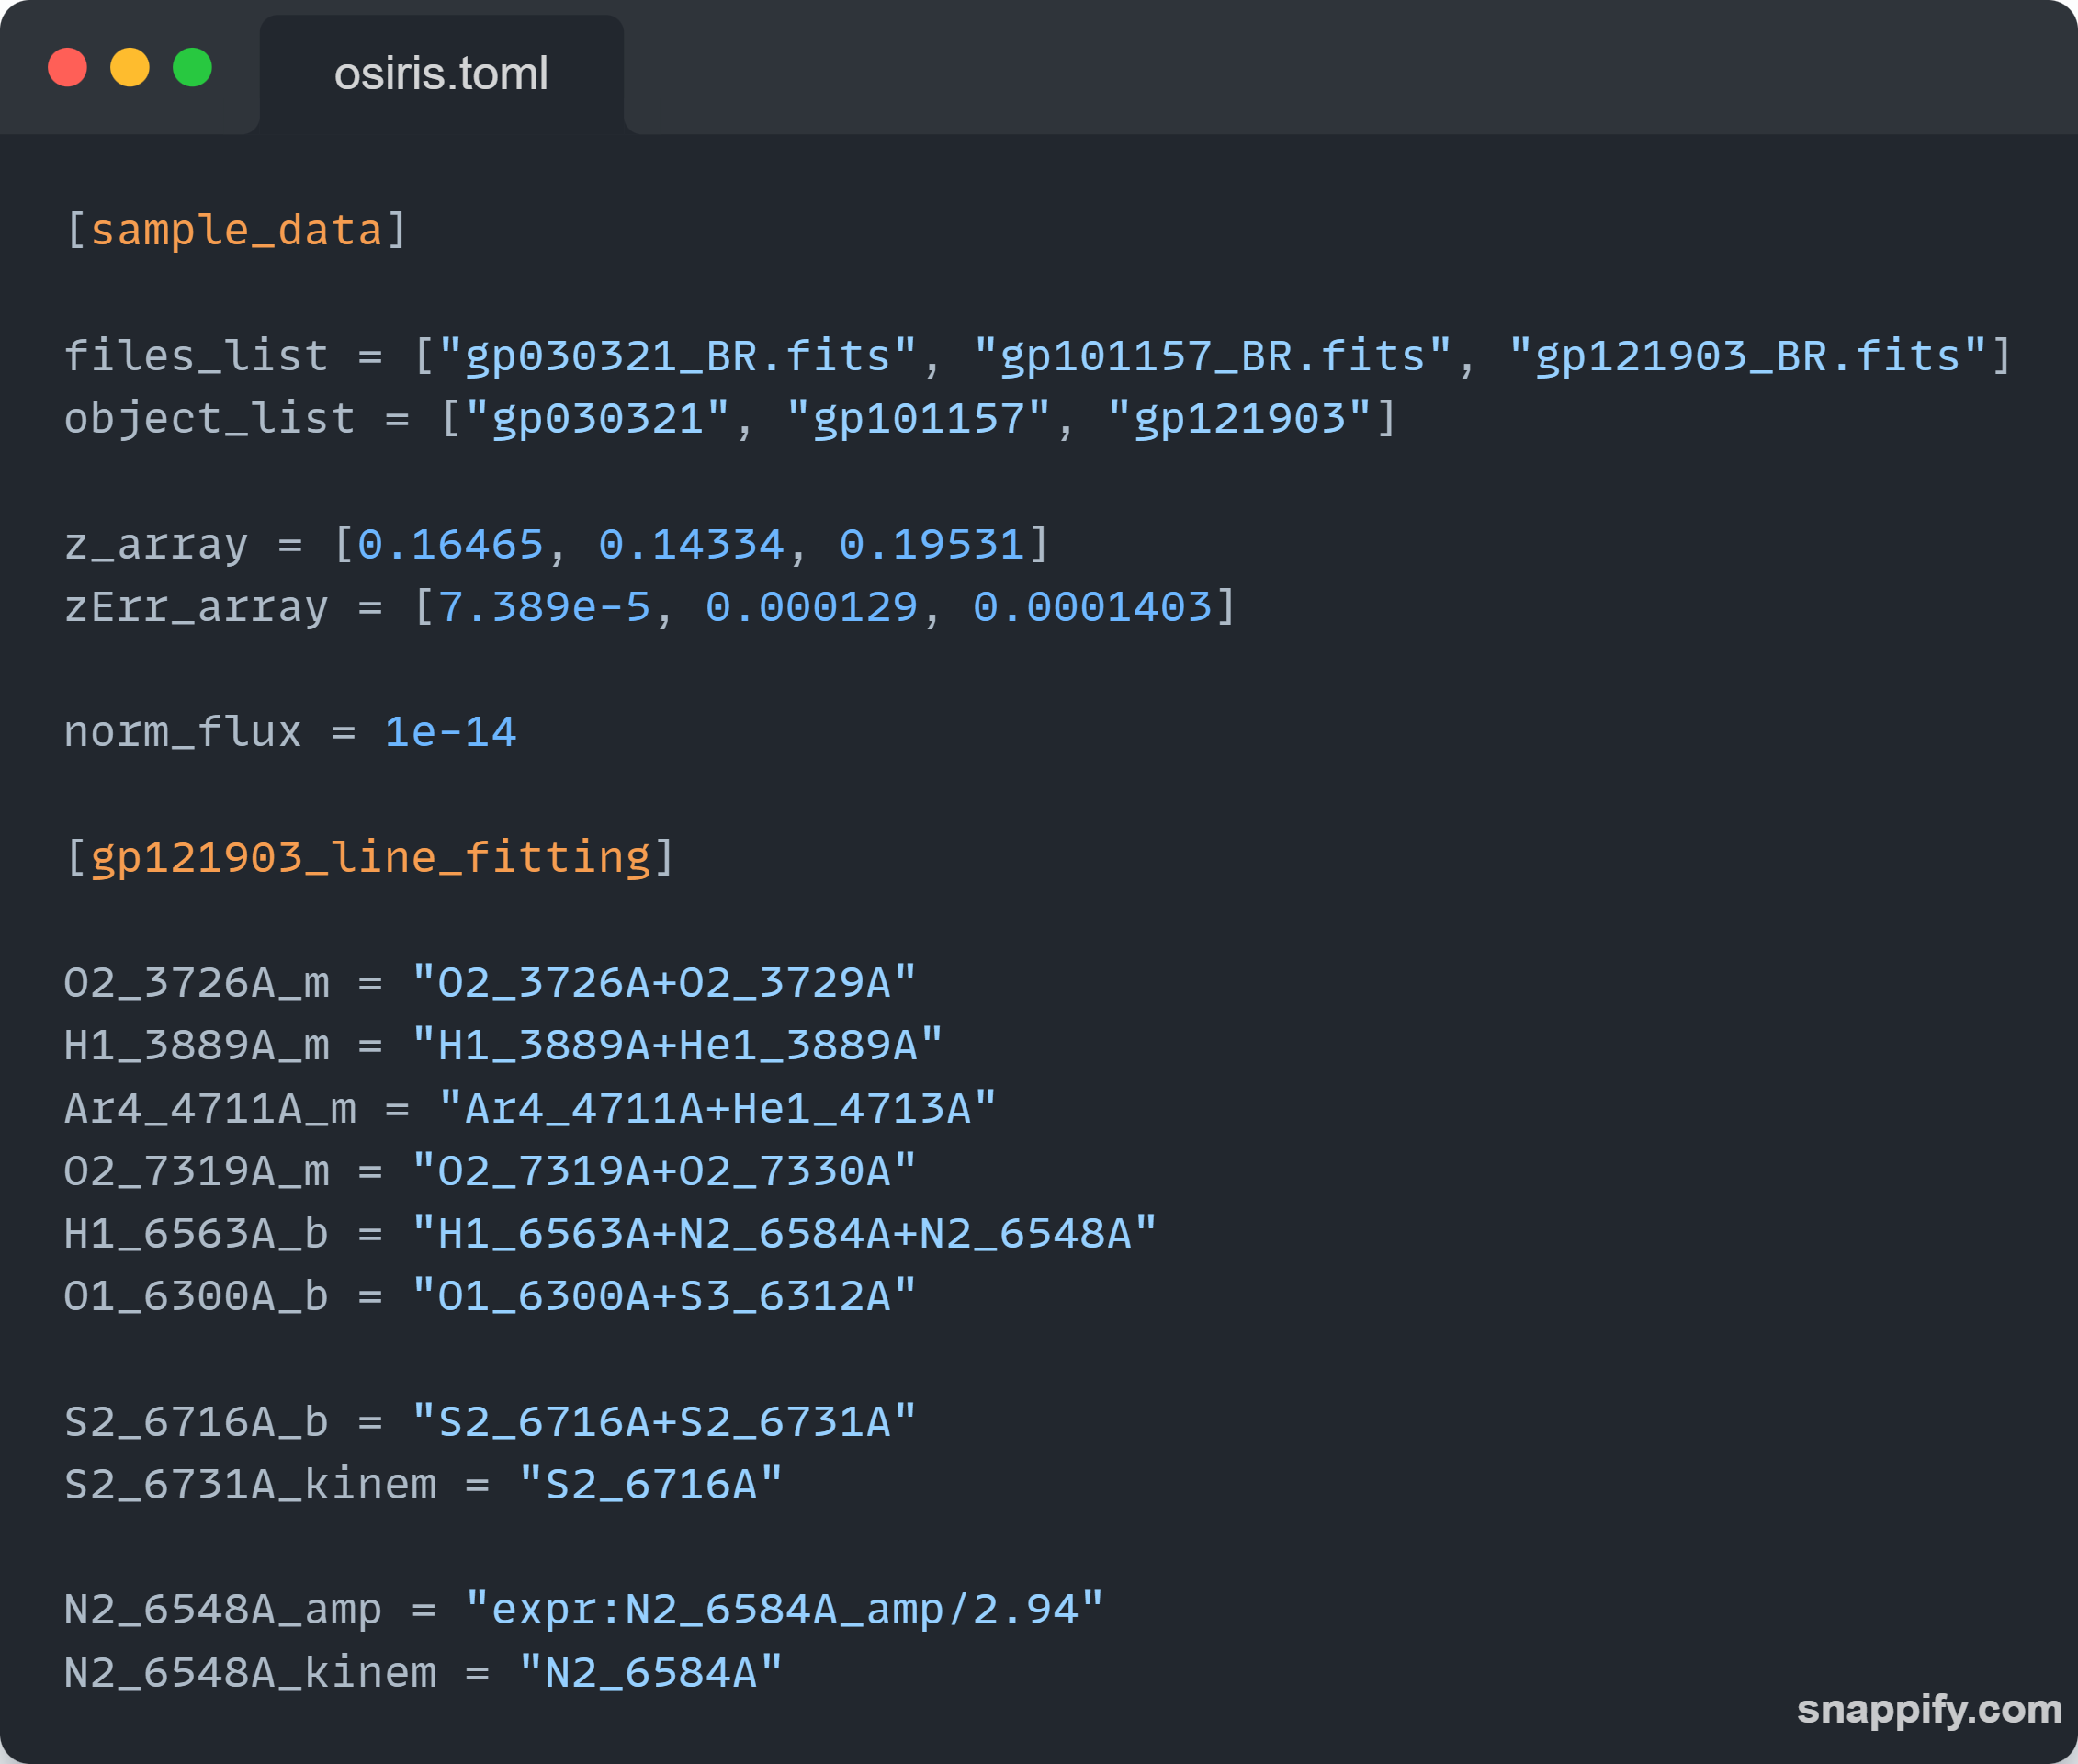

In [5]:
display(Image(filename='../images/conf_file_osiris.png'))

These configuration files consit in one or more sections, enclosed by squared brackets (**[section_name]**) with several properties/keys equal to their assigned value (**property = value**). The user is encouraged to read the [toml](https://toml.io/en/v1.0.0) examples to take full advantage on how to store variables on a text file. However, it is important to keep in mind the following constrains: 

* String properties must be surrounded by single ('my string') or double ("my string") quotation marks.
* By default Section and property names can only have ASCII letters, ASCII digits, underscores, and dashes. If you want to use additional character you need to declare them as strings (using single or double quotation marks). The latter option is not recomended though.
* Section and property names should not use dots. In configuration files dots are used to declare key-value substructures. If you section or property label needs them you can use using single or double quotation marks.

You can use the ``lime.load_cfg`` function to read these files as a dictionary of dictionaries:

In [6]:
obs_cfg = lime.load_cfg(configFile)
obs_cfg

{'sample_data': {'files_list': ['gp030321_BR.fits',
   'gp101157_BR.fits',
   'gp121903_BR.fits'],
  'object_list': ['gp030321', 'gp101157', 'gp121903'],
  'z_array': [0.16465, 0.14334, 0.19531],
  'zErr_array': [7.389e-05, 0.000129, 0.0001403],
  'norm_flux': 1e-17},
 'default_line_fitting': {'O2_3726A_m': 'O2_3726A+O2_3729A',
  'H1_3889A_m': 'H1_3889A+He1_3889A',
  'Ar4_4711A_m': 'Ar4_4711A+He1_4713A',
  'O2_7319A_m': 'O2_7319A+O2_7330A'},
 'gp121903_line_fitting': {'O1_6300A_b': 'O1_6300A+S3_6312A',
  'O3_5007A_b': 'O3_5007A+O3_5007A_k-1',
  'O3_5007A_k-1_amp': {'expr': '<100.0*O3_5007A_amp', 'min': 0.0},
  'O3_5007A_k-1_sigma': {'expr': '>2.0*O3_5007A_sigma'},
  'H1_6563A_b': 'H1_6563A+N2_6584A+N2_6548A',
  'N2_6548A_amp': {'expr': 'N2_6584A_amp/2.94'},
  'N2_6548A_kinem': 'N2_6584A',
  'S2_6716A_b': 'S2_6716A+S2_6731A',
  'S2_6731A_kinem': 'S2_6716A'}}

<div class="alert alert-info">

**Please remember:** If one of the sections in your configuration files has the **_line_fitting** suffix, $LiMe$ transforms some of the key values so they can be used directly in the functions. For example the property value:

   ``N2_6548A_amp = "expr:N2_6584A_amp/2.94"``
    
is converted into a dictionary:
    
   ``N2_6548A_amp : {'expr': 'N2_6584A_amp/2.94'}``

The user is encourge to use **_line_fitting** suffix in sections with data for $LiMe$ fittings. This will make sure the inputs are formatted to the expected format.    
</div>

Beyond $LiMe$ fitting parameters you can store any kind of information on this file:

In [7]:
z_obj = obs_cfg['sample_data']['z_array'][2]
norm_flux = obs_cfg['sample_data']['norm_flux']

In [8]:
# Declare LiMe spectrum
gp_spec = lime.Spectrum(wave, flux, redshift=z_obj, norm_flux=norm_flux)

## Blended and merged line components:

We can see that in the ``[gp121903_line_fitting]`` section there are several [blended](https://lime-stable.readthedocs.io/en/latest/inputs/2_Line_labels.html#Blended-line) and [merged](https://lime-stable.readthedocs.io/en/latest/inputs/2_Line_labels.html#Merged-line) lines:

In [12]:
# Section with the fitting information:
fit_cfg = obs_cfg['gp121903_line_fitting']

In [13]:
# Some lines with the multiple components:
obs_cfg['default_line_fitting']['H1_3889A_m'], obs_cfg['gp121903_line_fitting']['S2_6716A_b']

('H1_3889A+He1_3889A', 'S2_6716A+S2_6731A')

If we provide these components in the fitting (and the **_b** suffix is included in the line label) multiple components will be fitted: 

<IPython.core.display.Javascript object>


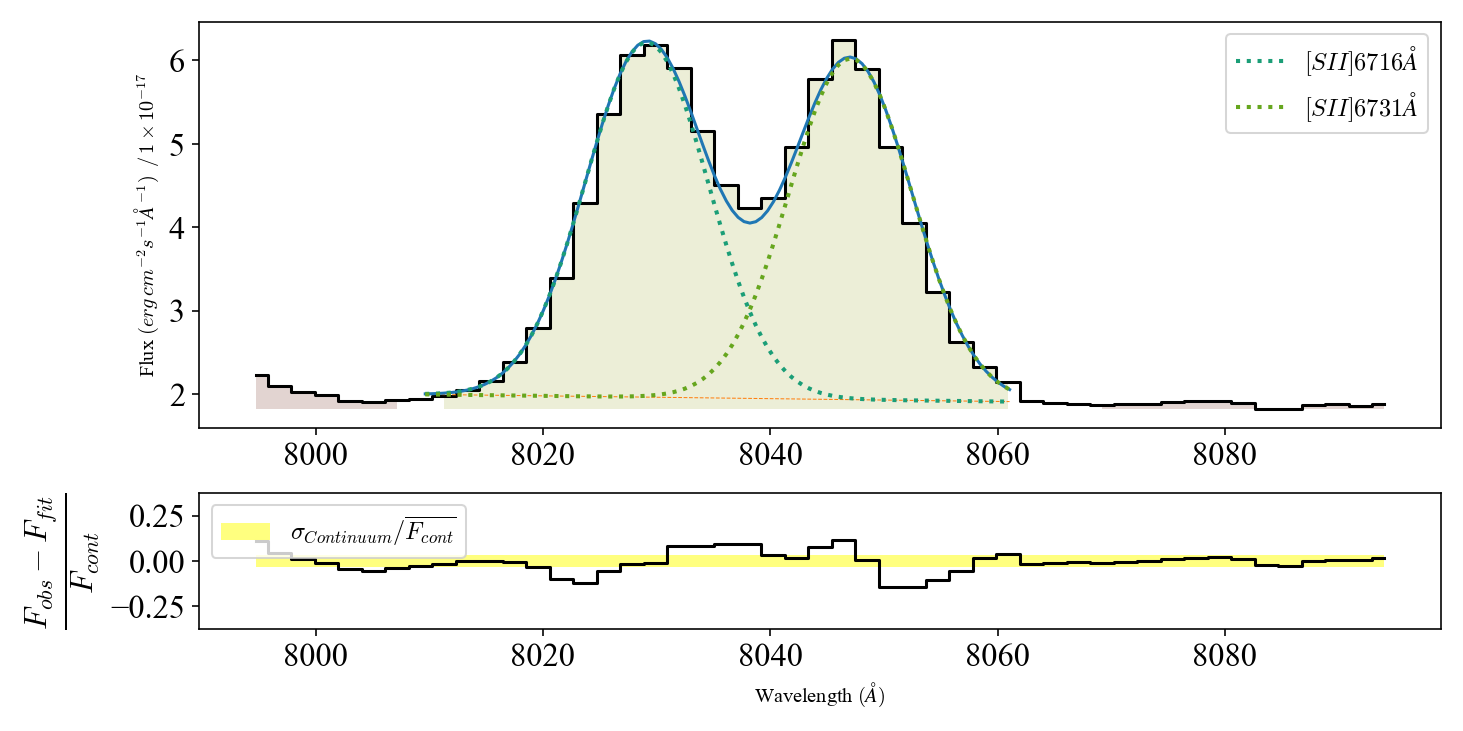

In [14]:
# Fit and plot of a blended line with two components
gp_spec.fit.bands('S2_6716A_b', bands_df, fit_cfg)
gp_spec.plot.bands('S2_6716A_b')

<div class="alert alert-info">

**Please remember:** The components for a blended or merged line must follow the [line label notation](https://lime-stable.readthedocs.io/en/latest/inputs/2_Line_labels.html#) joined with the plus **(+)** symbol.
</div>

## Model parameters:

$LiMe$ solves the mathematical model using [LmFIT](https://lmfit.github.io/lmfit-py/). For each line we define 3 [parameters](https://lmfit.github.io/lmfit-py/parameters.html) per component in the equation above plus 2 more for the local continuum. These are labeled using the line name and the following suffixes:

* **_amp**: the height of the Gaussian from the continuum in the spectrum flux (normalised) units.
* **_center**: the wavelength of the Gaussian peak in the spectrum wavelength units.
* **_sigma**: the width of the Gaussian curve in the spectrum wavelength units.
* **_cont_slope**: the local continuum gradient. In blended lines, there is only one continuum labeled after the first component.
* **_cont_intercept**: the linear flux at zero wavelength for the local continuum. In blended lines there is still only one continuum intercept labeled after the first component.


<div class="alert alert-info">

**Please remember:** It should be explained that we are not using the default [Gaussian model](https://lmfit.github.io/lmfit-py/builtin_models.html#lmfit.models.GaussianModel) in LmFit:
   Their in-built model defines the amplitude $A_{i}$ as the area under the Gaussian profile. While this notation
   provides a cleaner mathematical description, in the fitting of astronomical spectra it is seldom easy to constrain
   the flux in advance. Instead, it is easier to impose limits on the line height, which is our definition.
</div>

In your configuration file, you can adjust the fitting for each of these parameters with the by adding line label followed by the corresponding suffix. For example, in the $[NII]6548Å$ we constrained its amplitude:
```
H1_6563A_b = "H1_6563A+N2_6584A+N2_6548A"
N2_6548A_amp = "expr:N2_6584A_amp/2.94"
N2_6548A_kinem = "N2_6584A"
```

There are five attributes you can use to adjust the fitting on the [parameters](https://lmfit.github.io/lmfit-py/parameters.html):

* ``value``: Initial value for the parameter. $LiMe$ provides an initial guess for the parameters from
  the [integrated measurements](https://lime-stable.readthedocs.io/en/latest/documentation/measurements.html#integrated-properties).
* ``vary``: Whether the parameter is free during the fitting (default is True). If set to *False* the initial ``value`` will remain unchanged.
* ``min``: Lower bound for the parameter value. The default is value is -numpy.inf (no lower bound).
* ``max``: Upper bound for the parameter value. The default is value is numpy.inf (no upper bound).
* ``expr``: Mathematical expression to constrain the value during the fit. The default value is None.

<div class="alert alert-info">

**Please remember:** In the configuration file, the line parameters attributes are comma **(,)** separated and the key-value entries are separated by a colon **(:)**.
</div>

The ``expr`` parameter can be used to link the fitting to other components (if those components belong to the current fitting). For example, in the case above we are tiding the $[NII]6548Å$ amplitude to the one of $[NII]6584Å$ given theoretical emissivity relation between these transitions (2.94, which is constant independently of the physical conditions):

<IPython.core.display.Javascript object>


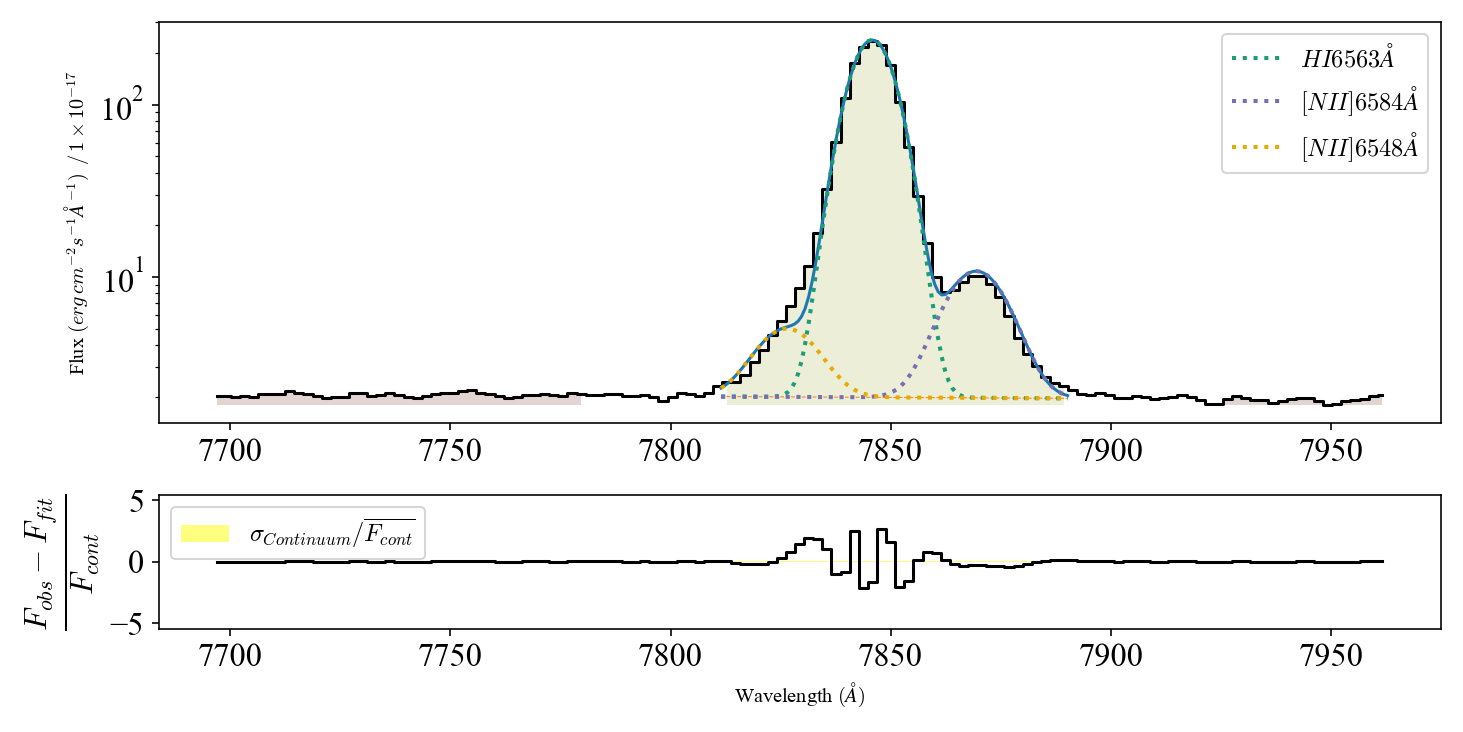

In [15]:
# Fit and plot of a line with a parameter using the "expr" :
gp_spec.fit.bands('H1_6563A_b', bands_df, fit_cfg)
gp_spec.plot.bands()

This is a convenient way to tie the flux between lines in the same blended groups. As you can see from the plot above the Gaussin flux ratio between both transitions is very close to the theoretical ratio. This can also be concluded from the measurements log:

In [16]:
N2_flux_ratio = gp_spec.log.loc["N2_6584A", "gauss_flux"]/gp_spec.log.loc["N2_6548A", "gauss_flux"]
print(f'[NII] doublet gaussian flux ratio: {N2_flux_ratio}')

[NII] doublet gaussian flux ratio: 2.956163711944168


Similarly, if we want to fit the weak wide component of $[OIII]5007Å$ we can use the command:

```
O3_5007A_b = 'O3_5007A+O3_5007A_k-1'
O3_5007A_sigma = "value:2,max:4"
O3_5007A_k-1_sigma = "value:5,min:4.0"
```

<IPython.core.display.Javascript object>


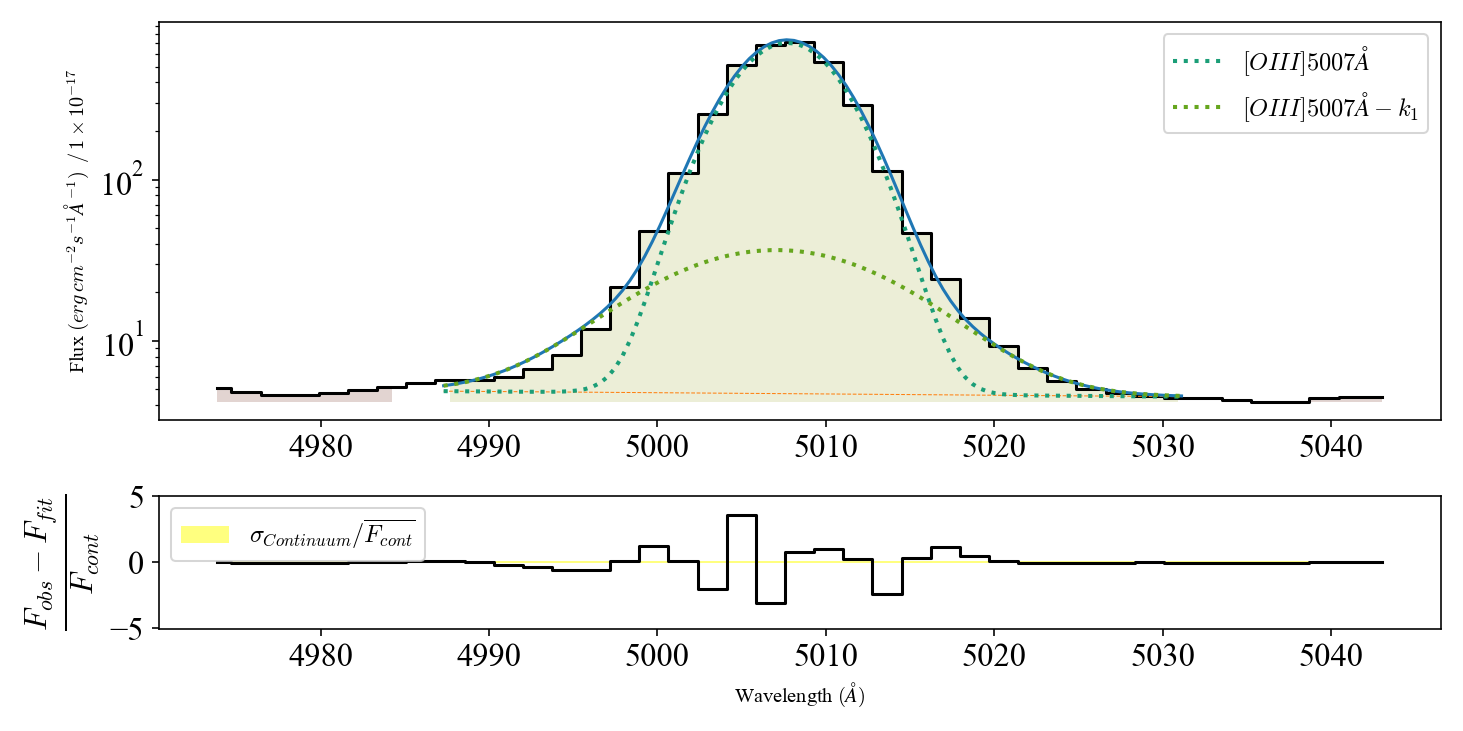

In [17]:
gp_spec.fit.bands('O3_5007A_b', bands_df.loc['O3_5007A', 'w1':'w6'], fit_cfg)
gp_spec.plot.bands('O3_5007A_b', rest_frame=True)

## Inequality boundary conditions:

$LiMe$ includes the posibility to add inequalities in [LmFIT](https://lmfit.github.io/lmfit-py/) ``expr`` parameter. For example, the $[OIII]5007Å$ wide component could be fit using two inequalities:

<IPython.core.display.Javascript object>


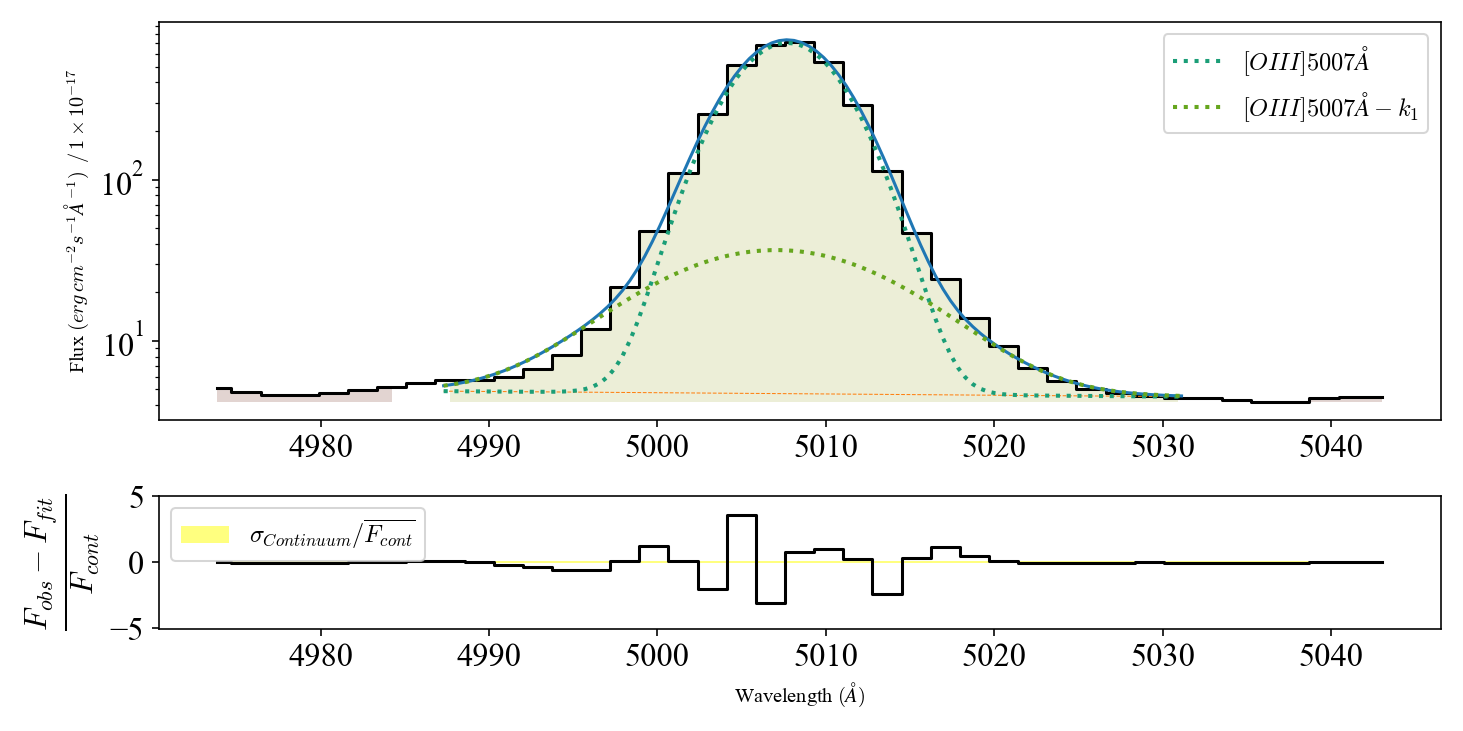

In [18]:
# Same line fitting but using inequalities
O3_ineq_cfg = {'O3_5007A_b'         : 'O3_5007A+O3_5007A_k-1',
               'O3_5007A_k-1_amp'   : {'expr': '<100.0*O3_5007A_amp', 'min': 0.0},
               'O3_5007A_k-1_sigma' : {'expr': '>2.0*O3_5007A_sigma'}}
gp_spec.fit.bands('O3_5007A_b', bands_df.loc['O3_5007A', 'w1':'w6'], O3_ineq_cfg)
gp_spec.plot.bands("O3_5007A_b", rest_frame=True)

In this case we have provided two inequalities for the amplitude and sigma of the Gaussian profile of the ```O3_5007A_k-1```.

It is important for the user to realize that it is essential to include these contrains for the fitting of multiple kinematic components even if the instrument resolution is high enough. This is because the algorithm may interchange the fitting label (k-0, k-1,...) from one line to another if the user does not provide any indication.

<div class="alert alert-info">

**Please remember:** In the current release only multiplication can be used along the inequality term. Please contact the author if you have any issue/request with this functionality.

</div>

## Importing external line kinematics:

While the amplitude of an emission profile is dominated by the emissivity of the corresponding transition and the gas physical conditions; its width is mostly dependant on the gas kinematics. Moreover, discrepancies with the theoretical wavelength are also due to the gas kinematics.

Consequently, in some cases it is useful to constrain the line velocity dispersion $(\sigma)$ and radial velocity in the line of sight $(v_{r})$ from the measurements of another line. For example:

$\sigma_{A} = \sigma_{B}$

$v_{r,\,A} = v_{r,\,B}$

where *A* and *B* are two line labels and both $v_{r}$ and $\sigma$ are in velocity units (for example $km/s$). To convert the equations above to the spectrum wavelength units, we use:

$\sigma_{A} = \sigma_{B}\cdot\frac{\lambda_{A}}{\lambda_{B}}\left(\text{Å}\right)$

$\mu_{A} = \mu_{B}\cdot\frac{\lambda_{A}}{\lambda_{B}}\left(\text{Å}\right)$



where $\mu$ and $\lambda$ are observed and theoretical transition wavelength respectively. The second term takes into consideration the object redshift.



In the configuration file, these two constrains can be set simultaneously with the **_kinem** suffix on the line importing the kinematics. For example, in the fitting of $H\alpha$ and the $[NII]6548,6584Å$ doublet we had:

```
H1_6563A_b = "H1_6563A+N2_6584A+N2_6548A"
N2_6548A_amp = "expr:N2_6584A_amp/2.94"
N2_6548A_kinem = "N2_6584A"
```
Resulting in:

<IPython.core.display.Javascript object>


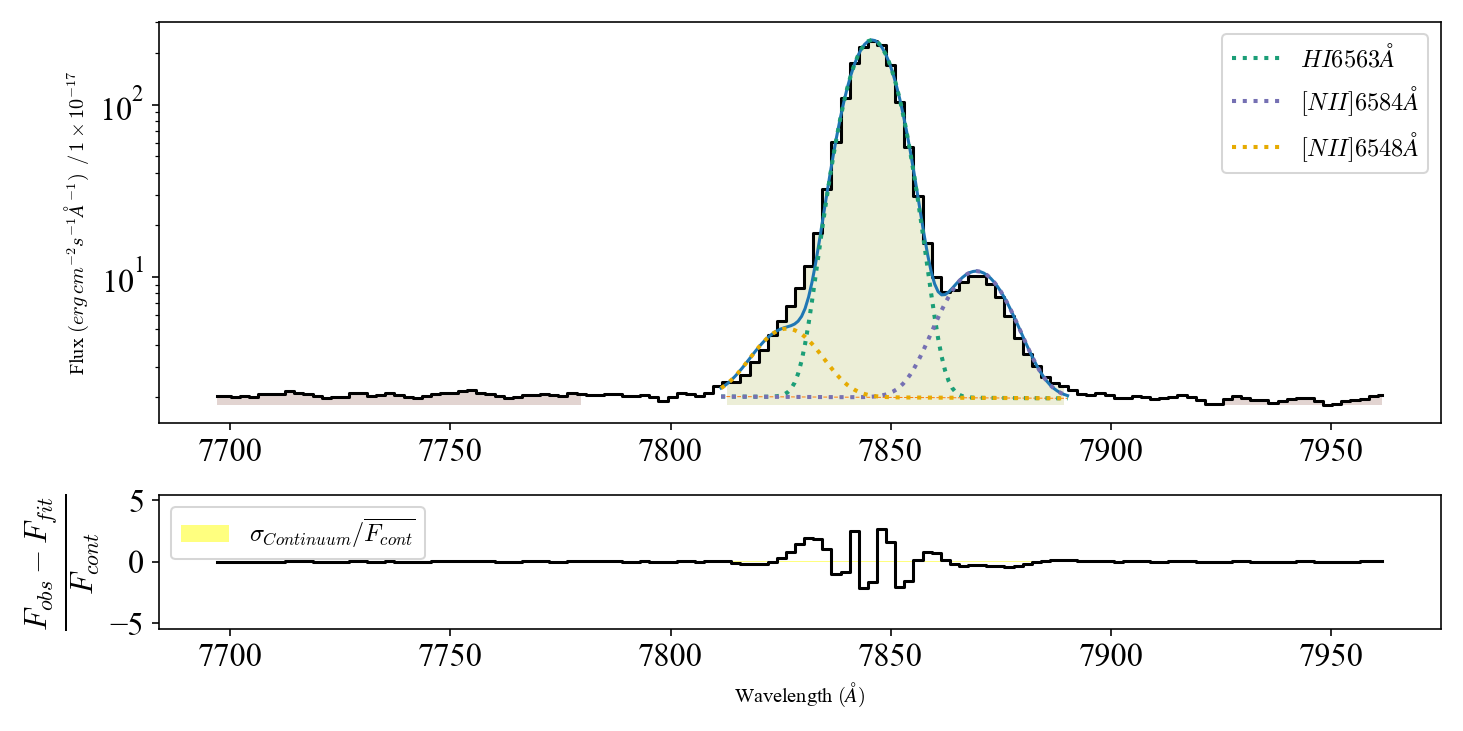

In [19]:
gp_spec.plot.bands('H1_6563A')

In this case, the kinematics of $[NII]6548,6584Å$ lines are tied together together during the fitting. However, we can also use this line to import the kinematics from a line measured previously. For example, we can measure $H\beta$:

<IPython.core.display.Javascript object>


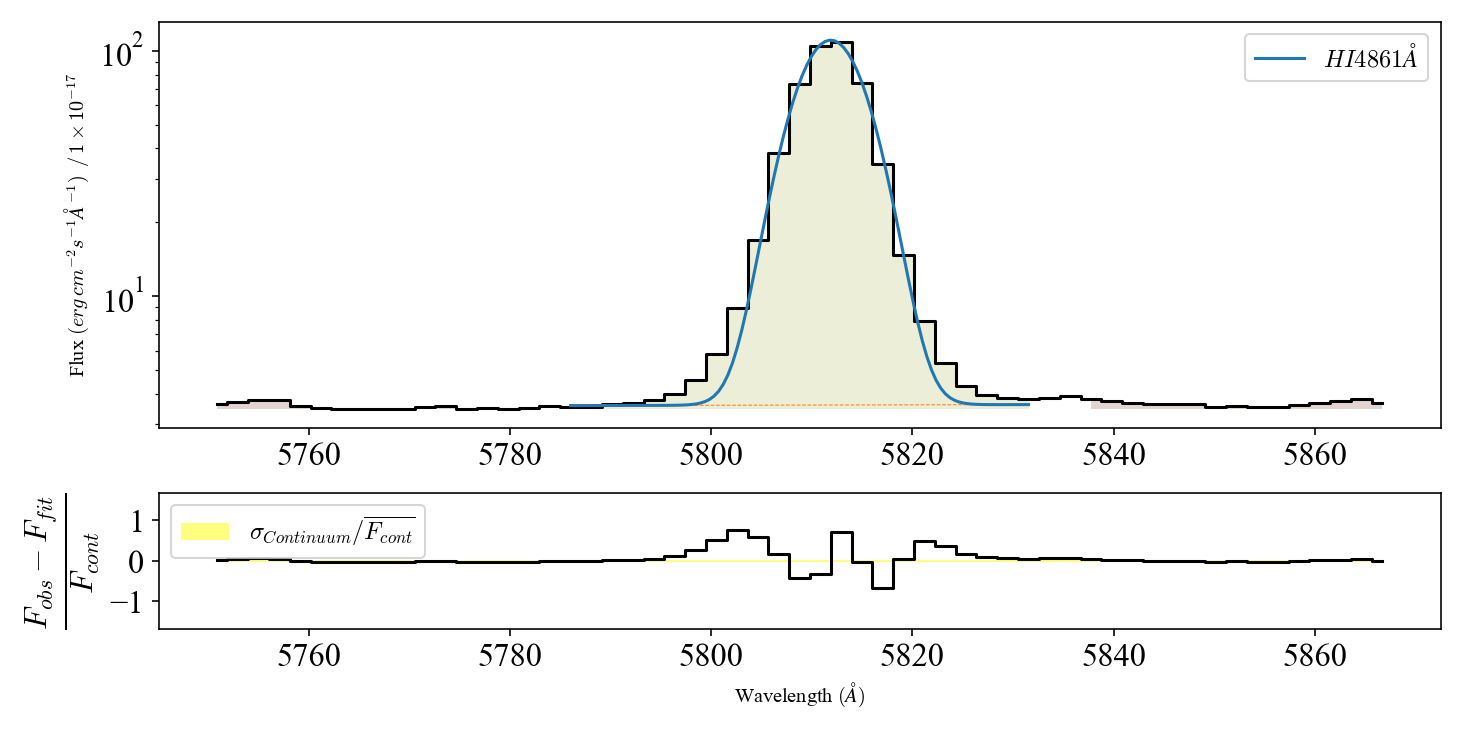

In [20]:
gp_spec.fit.bands('H1_4861A', bands_df, fit_cfg)
gp_spec.plot.bands()

And repeat the fitting imposing this line kinematics on the three transition:

<IPython.core.display.Javascript object>


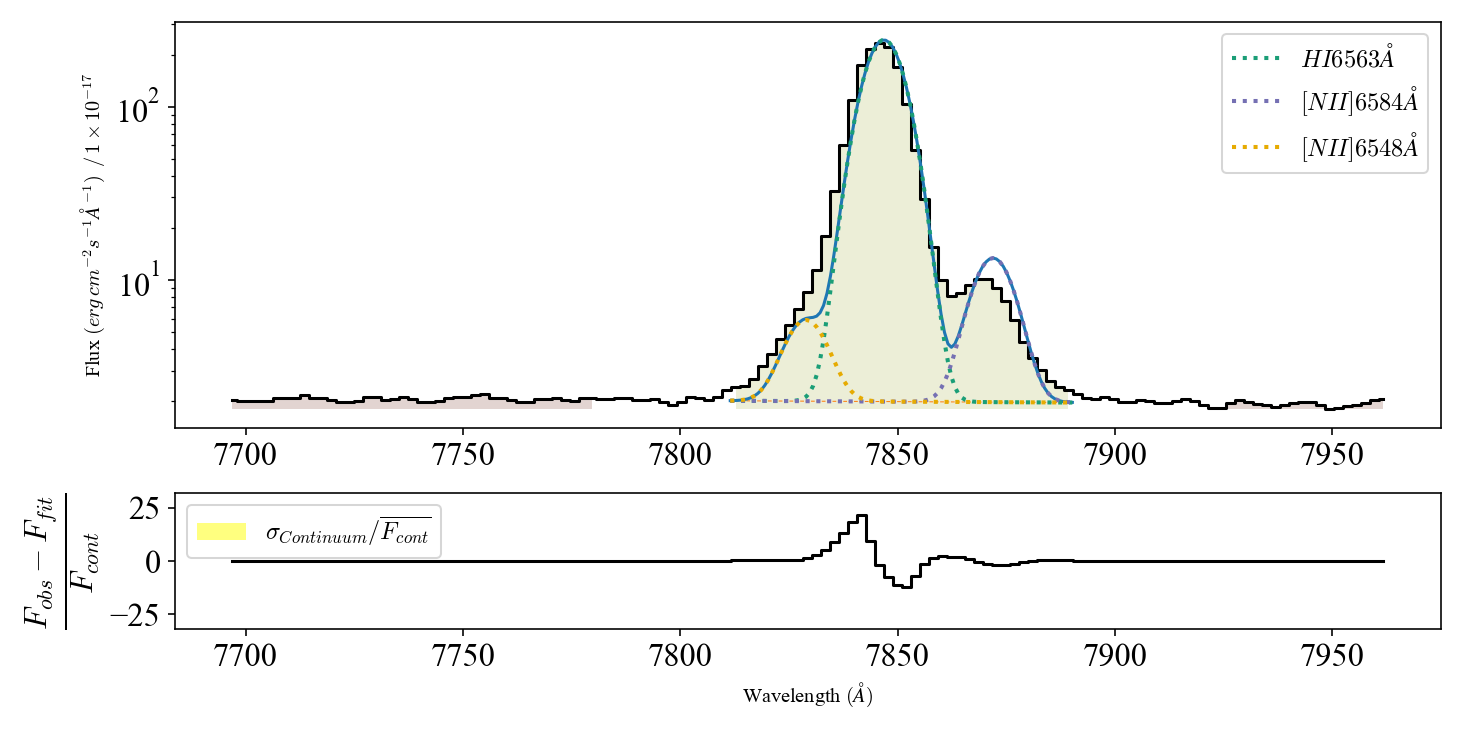

In [21]:
# Fit of a line importing the kinematics from an external line
Halpha_cfg = {'H1_6563A_b'      : 'H1_6563A+N2_6584A+N2_6548A',
              'H1_6563A_kinem'  : "H1_4861A",
              'N2_6584A_kinem'  : "H1_4861A",
              'N2_6548A_kinem'  : "H1_4861A",
              'N2_6548A_amp'    : {'expr': 'N2_6584A_amp/2.94'},
             }
gp_spec.fit.bands('H1_6563A_b', bands_df, Halpha_cfg)
gp_spec.plot.bands('H1_6563A_b')

From these results, you can see that the kinematics of $H\beta$ fit reasonable well in the $H\alpha$ aline. However, there are issues for the $[NII]$ doublet. This is due to the wide component of $H\alpha$.